# Project Title: Fashion MNIST Classification using CNN

- **Student Name:** Hassan Ali Mehdi
- **Course:** Digital Image Processing  
- **Roll Number:** SU92-BSCSM-F23-211

## Abstract
This project aims to develop a Convolutional Neural Network (CNN) to classify images from the Fashion MNIST dataset. The dataset consists of 60,000 training images and 10,000 testing images of various clothing items. The goal is to achieve high classification accuracy by leveraging deep learning techniques.

## Objective
The primary objective is to implement a deep learning model that can accurately categorize fashion articles into one of 10 classes: T-shirt/top, Trouser, Pullover, Dress, Coat, Sandal, Shirt, Sneaker, Bag, and Ankle boot.

## 1. Setup and Imports
In this section, we import the necessary libraries for data manipulation, visualization, and model building. We utilize TensorFlow and Keras for constructing the CNN.

In [8]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import tensorflow as tf
import math
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds


## 2. Data Acquisition
The dataset is loaded from local CSV files if available, or downloaded using TensorFlow Datasets (TFDS) as a fallback. This ensures reproducibility and flexibility in data sourcing.

In [9]:
# Define class names manually as we might not have metadata from TFDS
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

def load_data(data_dir='dataset'):
    train_path = os.path.join(data_dir, 'fashion-mnist_train.csv')
    test_path = os.path.join(data_dir, 'fashion-mnist_test.csv')
    
    if os.path.exists(train_path) and os.path.exists(test_path):
        print(f"Loading data from {data_dir}...")
        train_df = pd.read_csv(train_path)
        test_df = pd.read_csv(test_path)
        
        def process_df(df):
            labels = df.iloc[:, 0].values
            images = df.iloc[:, 1:].values
            images = images.reshape(-1, 28, 28, 1)
            return tf.data.Dataset.from_tensor_slices((images, labels))
            
        train_dataset = process_df(train_df)
        test_dataset = process_df(test_df)
        
        # Mock metadata object for compatibility
        class Metadata:
            def __init__(self):
                self.features = {'label': type('obj', (object,), {'names': class_names})}
                self.splits = {
                    'train': type('obj', (object,), {'num_examples': len(train_df)}),
                    'test': type('obj', (object,), {'num_examples': len(test_df)})
                }
        metadata = Metadata()
        
        return train_dataset, test_dataset, metadata
    else:
        print("Local data not found, attempting to download with TFDS...")
        dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
        return dataset['train'], dataset['test'], metadata

train_dataset, test_dataset, metadata = load_data()

Loading data from dataset...


In [10]:
class_names=metadata.features['label'].names
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## 3. Exploratory Data Analysis (EDA)
We examine the structure of the dataset, including the number of samples in the training and testing sets, and the distribution of classes.

### Dataset Statistics
The following output displays the count of examples in the training and testing splits, providing an overview of the data volume available for learning and evaluation.

In [11]:
num_train_examples=metadata.splits['train'].num_examples
num_test_examples=metadata.splits['test'].num_examples

print("Number of training examples : {}".format(num_train_examples))
print("number of testing examples : {}".format(num_test_examples))


Number of training examples : 60000
number of testing examples : 10000


## 4. Data Preprocessing
Preprocessing is a critical step in deep learning. We normalize the pixel values from the range [0, 255] to [0, 1] to facilitate faster convergence during training.

### Normalization Function
We define a function to cast image data to float32 and scale the values. This function is then mapped across the training and testing datasets.

In [12]:
def Normalize(images,labels):
    images=tf.cast(images,tf.float32)
    images/=255
    return images,labels


# The map function applies the normalize function to each element in the train
# and test datasets
train_dataset=train_dataset.map(Normalize)
test_dataset=test_dataset.map(Normalize)

# The first time you use the dataset, the images will be loaded from disk
# Caching will keep them in memory, making training faster

train_dataset=train_dataset.cache()
test_dataset=test_dataset.cache()


### 4.1 Visualization of Preprocessed Data
Visualizing a sample image ensures that the preprocessing steps have been applied correctly and allows us to verify the integrity of the image data.

2025-12-12 18:36:51.475069: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


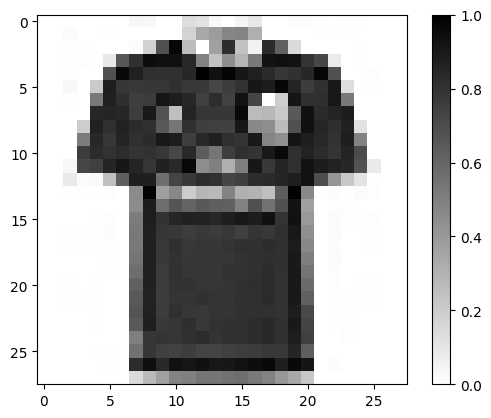

In [13]:
# Take a single image, and remove the color dimension by reshaping
for image, label in test_dataset.take(1):
    break
image = image.numpy().reshape((28, 28))


plt.figure()
plt.imshow(image, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()




2025-12-12 18:36:51.765650: W tensorflow/core/kernels/data/cache_dataset_ops.cc:858] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


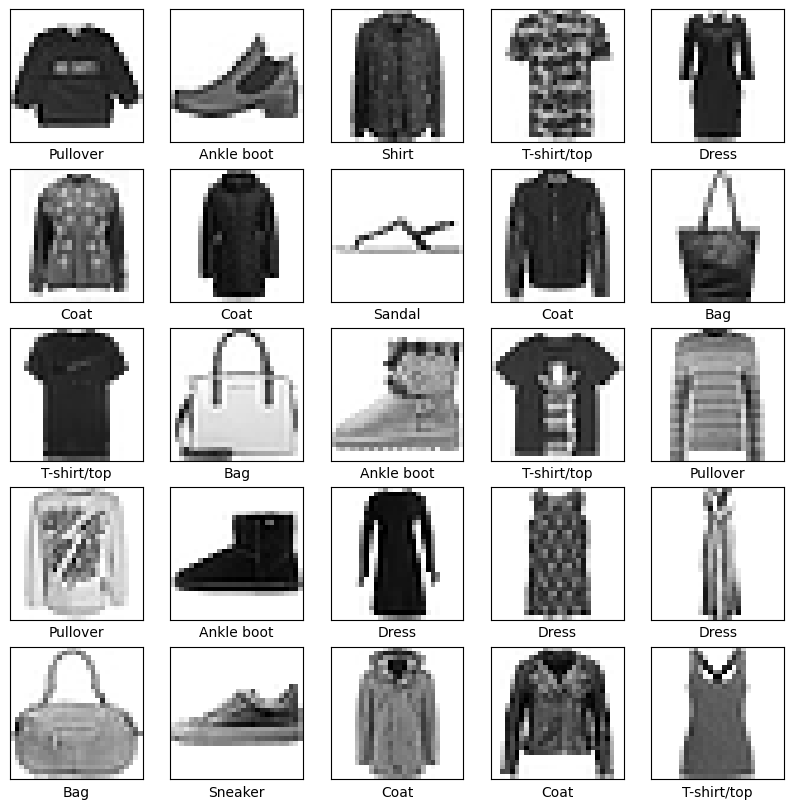

In [14]:
plt.figure(figsize=(10,10))
for i,(image,label) in enumerate(train_dataset.take(25)):
    image=image.numpy().reshape((28,28))
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(image,cmap=plt.cm.binary)
    plt.xlabel(class_names[label])
plt.show()
    


## 5. Model Architecture
We construct a Sequential CNN model with the following layers:
- **Convolutional Layers**: To extract spatial features from the images.
- **MaxPooling Layers**: To reduce dimensionality and computation.
- **Flatten Layer**: To convert 2D feature maps into a 1D vector.
- **Dense Layers**: Fully connected layers for classification.

In [15]:
model=tf.keras.Sequential([
    tf.keras.layers.Conv2D(32,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Conv2D(64,(3,3),padding='same',activation=tf.nn.relu,input_shape=(28,28,1)),
    tf.keras.layers.MaxPooling2D((2,2),strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128,activation=tf.nn.relu),
   tf.keras.layers.Dense(10,activation=tf.nn.softmax)    
])

### 5.1 Model Compilation
The model is compiled using the Adam optimizer and Sparse Categorical Crossentropy loss function, which is suitable for multi-class classification problems.

In [16]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(),metrics=['accuracy'])

## 6. Model Training
The model is trained on the training dataset for a specified number of epochs. We use batching and shuffling to ensure efficient and robust learning.

In [17]:
BATCH_SIZE = 32
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [18]:
model.fit(train_dataset,epochs=20,steps_per_epoch=math.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/20


1875/1875 [==============================] - 8s 4ms/step - loss: 0.4030 - accuracy: 0.8545
Epoch 2/20
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4030 - accuracy: 0.8545
Epoch 2/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2669 - accuracy: 0.9031
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2669 - accuracy: 0.9031
Epoch 3/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2188 - accuracy: 0.9205
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.2188 - accuracy: 0.9205
Epoch 4/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1826 - accuracy: 0.9325
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1826 - accuracy: 0.9325
Epoch 5/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1564 - accuracy: 0.9416
Epoch 6/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.1564 - accuracy

## 8. Model Export
Save the trained CNN to disk for reuse or deployment.

In [ ]:
import pathlib
export_dir = pathlib.Path('models')
export_dir.mkdir(parents=True, exist_ok=True)

model_path = export_dir / 'fashion_mnist_cnn.h5'
model.save(model_path)
print(f"Model saved to {model_path.resolve()}")

Model saved to /root/cnnbasedfashion/models/fashion_mnist_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
import pathlib
export_dir = pathlib.Path('models')
export_dir.mkdir(parents=True, exist_ok=True)

model_path = export_dir / 'fashion_mnist_cnn.h5'
model.save(model_path)
print(f"Model saved to {model_path.resolve()}")

Model saved to /root/cnnbasedfashion/models/fashion_mnist_cnn.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## 7. Model Evaluation
After training, we evaluate the model's performance on the unseen test dataset to determine its generalization capability and accuracy.

In [19]:
test_loss,test_accuracy=model.evaluate(test_dataset,steps=math.ceil(num_test_examples/32))
print(f'The accuracy on test dataset is :{test_accuracy}')

 85/313 [=======>......................] - ETA: 0s - loss: 0.4829 - accuracy: 0.9210

313/313 [==============================] - 1s 2ms/step - loss: 0.4562 - accuracy: 0.9228
The accuracy on test dataset is :0.9228000044822693
313/313 [==============================] - 1s 2ms/step - loss: 0.4562 - accuracy: 0.9228
The accuracy on test dataset is :0.9228000044822693


## 8. Prediction and Analysis
Finally, we use the trained model to make predictions on individual images from the test set. We visualize the predictions alongside the true labels and confidence scores to analyze the model's behavior.

In [20]:
for test_images, test_labels in test_dataset.take(1):
  test_images = test_images.numpy()
  test_labels = test_labels.numpy()
  predictions = model.predict(test_images)

1/1 [==============================] - 0s 62ms/step


In [21]:
predictions.shape

(32, 10)

In [22]:
predictions[0]

array([1.00000000e+00, 5.22062470e-18, 1.36447367e-10, 3.54867736e-15,
       2.23256857e-10, 1.26901104e-14, 2.88794375e-08, 3.39836411e-21,
       6.78522691e-18, 1.25301725e-17], dtype=float32)

In [23]:
np.argmax(predictions[0])

0

In [24]:
test_labels[0]

0

In [25]:
def plot_image(i, predictions_array, true_labels, images):
  predictions_array, true_label, img = predictions_array[i], true_labels[i], images[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array[i], true_label[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1]) 
  predicted_label = np.argmax(predictions_array)
  
  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')

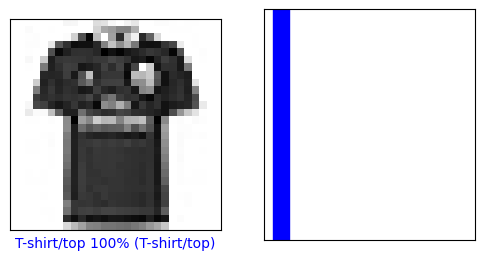

In [26]:
i = 0
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

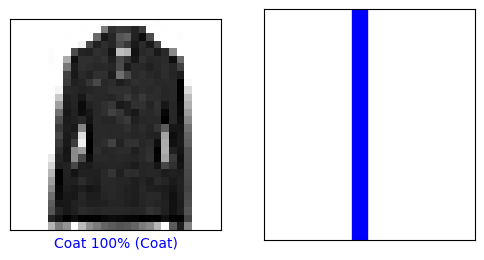

In [27]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions, test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions, test_labels)

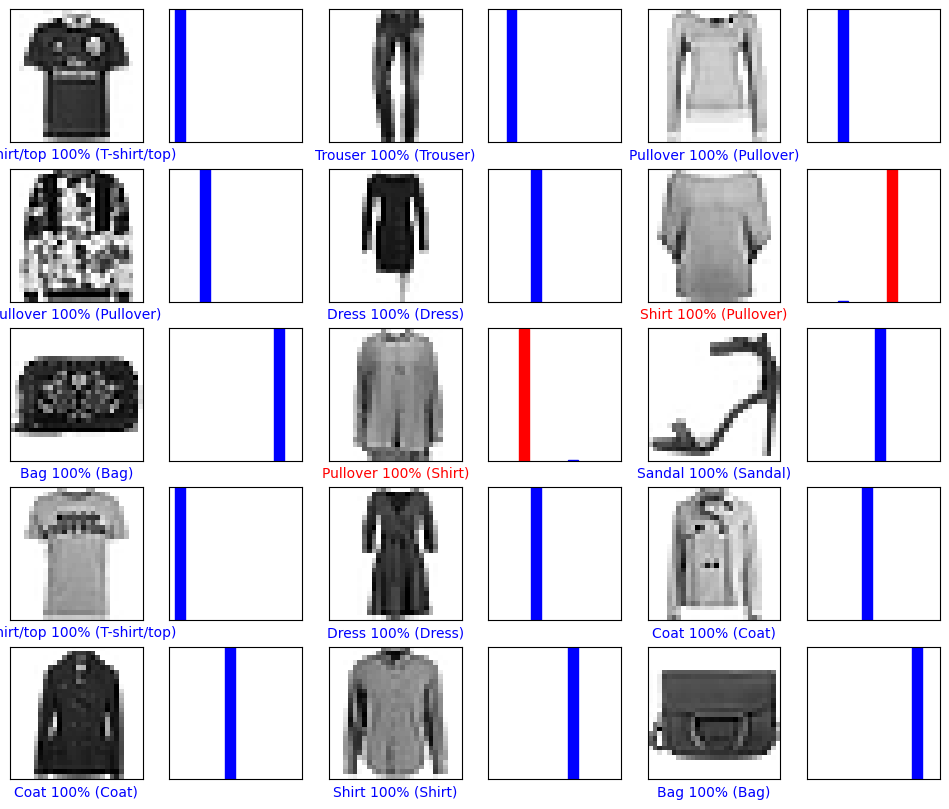

In [28]:
# Plot the first X test images, their predicted label, and the true label
# Color correct predictions in blue, incorrect predictions in red
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions, test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions, test_labels)


In [29]:
# Grab an image from the test dataset
img = test_images[0]

print(img.shape)

(28, 28, 1)


In [30]:
# Add the image to a batch where it's the only member.
img = np.array([img])

print(img.shape)

(1, 28, 28, 1)


In [31]:
predictions_single = model.predict(img)

print(predictions_single)

1/1 [==============================] - 0s 44ms/step
[[1.0000000e+00 5.2205651e-18 1.3644737e-10 3.5486367e-15 2.2325729e-10
  1.2690087e-14 2.8879438e-08 3.3983512e-21 6.7852269e-18 1.2530268e-17]]
1/1 [==============================] - 0s 44ms/step
[[1.0000000e+00 5.2205651e-18 1.3644737e-10 3.5486367e-15 2.2325729e-10
  1.2690087e-14 2.8879438e-08 3.3983512e-21 6.7852269e-18 1.2530268e-17]]


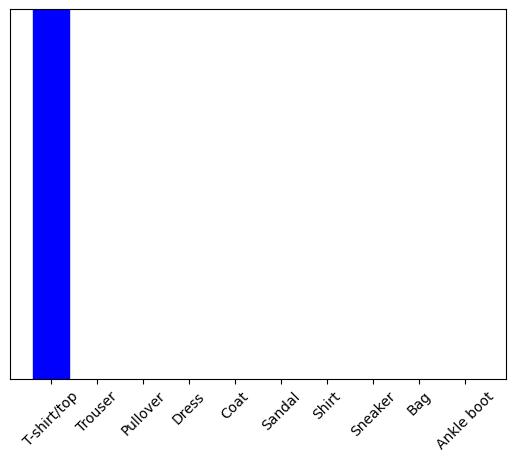

In [32]:
plot_value_array(0, predictions_single, test_labels)
_ = plt.xticks(range(10), class_names, rotation=45)

In [33]:
np.argmax(predictions_single[0])

0